## What we are going to cover in this notebook -
1. Setup _ Importing modules from the previous notebooks
2. Introduce Experiment Tracking with Pytorch
3. Building several modeling experiments for foodvision_mini
4. Evaluating model experiments with Tensorboard
5. Making predictions with the best performing model on custom dataset

1. We do experiment tracking to know which experiments are worth pursuing.
2. It helps us to figure out what does'nt work so that we can figure out what does work.

In [1]:
import torch
import torchvision

In [2]:
import going_modular

In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
import torchinfo

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# defining a global set seed function
def set_seeds(seed: int=95):
    """
    Set random sets for torch operations.

    Args:
    seed(int, optional): Random seed to set
    """
    # set the seed for general torch operations
    torch.manual_seed(seed)
    # set the seed for cuda torch operations
    torch.cuda.manual_seed(seed)

In [15]:
set_seeds()

## 1. Writing function to functionalize extraction of data

In [16]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                 destination: str,
                 remove_download: bool = True) -> Path:
    
    """ Downloads a zipped dataset from the given source link and unzips the file to the destination folder"""

    # setup path to data folder
    data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
    image_path = data_path /destination

    # Check if the image folder exists or not, if it does not exist, create one
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, so skipping download ....")
    else:
        print(f"[INFO] {image_path} does not exist. Creating one ----")
        image_path.mkdir(parents = True, exist_ok = True)

        # Downloading of the target data
        target_file = Path(source).name
        with open(data_path /target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from the source - {source} ....")
            f.write(request.content)

        # Unzip the target file
        with zipfile.ZipFile(data_path/target_file, "r") as zip_file:
            print(f"[INFO] Unzipping the target file - {target_file} ....")
            zip_file.extractall(image_path)

        # Remove the downloaded zip file
        if remove_download:
            os.remove(data_path/target_file)
    
    return image_path

In [17]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination = "pizza_steak_sushi")
image_path

[INFO] /Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi directory already exists, so skipping download ....


PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi')

#### We are working on a new image classification data -> dragon_ball_z_character_classification_data

### 2. Create Datasets and DataLoaders

#### The goal of the transforms is to ensure that the custom data is formatted in a reproducible way which is suitable for the pretrained models which we are using

In [18]:
image_path

PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi')

In [19]:
# setup path to data folder
data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
image_path = data_path / "dragon_ball_images"

In [20]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [21]:
train_dir, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/test'))

#### Setup ImageNet Normalization Levels - MANUAL

In [23]:
normalize_manual = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                       std = [0.229, 0.224, 0.225])

In [24]:
# Create transform pipeline manually
from torchvision import transforms
manual_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize_manual])

print(f"Manually Created Transforms: {manual_transforms}")

Manually Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [26]:
# Creating dataloaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir= train_dir,
                                                                             test_dir= test_dir,
                                                                             transform=manual_transforms,
                                                                             batch_size = 32,
                                                                             num_workers = 0)

In [27]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15b355090>,
 ['goku', 'picolo', 'trunks', 'vegeta'])

#### Creating DataLoader using automatically issued Transforms - Automatically
We want our custom data to be transformed in the same way our pretrained model data is trained.

## We can initialize transforms that we want to use for a certain pretrained model from the WEIGHTS of that pretrained model.
example - 
weights = ResNet50_weights.DEFAULT
transform = weights.transforms()

In [31]:
import torchvision

In [32]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [33]:
# Get transforms from weights (these are the transforms used to train a particular set of data from weights)
auto_transform = weights.transforms()

In [34]:
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [35]:
# creating train_dataloader, test_dataloader, class_names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir = train_dir,
                                                                             test_dir= test_dir,
                                                                             transform=auto_transform,
                                                                             batch_size = 32,
                                                                             num_workers= 0)

In [36]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15929a410>,
 ['goku', 'picolo', 'trunks', 'vegeta'])

### 3. Getting a pretrained model, freezing the base layers and changing the classifier layer as per requirements

In [37]:
# Download the pretrained weights of the desired model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [41]:
# Freezing all the base layers by setting their required_grad to false and customizing the classifier layer
for params in model.features.parameters():
    #print(params)
    params.requires_grad = False

In [42]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [43]:
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.02, inplace = True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias = True)
)

In [44]:
model.classifier

Sequential(
  (0): Dropout(p=0.02, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

In [45]:
# Printing the summary of the model
from torchinfo import summary
summary(model=model,
       input_size = (32,3,2254,224),
       verbose = 0,
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 2254, 224]   [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 2254, 224]   [32, 1280, 71, 7]    --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 2254, 224]   [32, 32, 1127, 112]  --                   False
│    │    └─Conv2d (0)                                       [32, 3, 2254, 224]   [32, 32, 1127, 112]  (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 1127, 112]  [32, 32, 1127, 112]  (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 1127, 112]  [32, 32, 1127, 112]  --                   --
│    └─Sequential (1)                                        [32, 32, 1127, 112]  [32, 

### 4. Train a Model and track results

In [46]:
# Define Loss and Optimizer Functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.01)

1. To Track the experiments, we are going to use Tensorboard - https://www.tensorflow.org/tensorboard
2. How to use tensorboard with pytorch. -https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter

In [47]:
# Settingup Summarywriter
from torch.utils.tensorboard import SummaryWriter

In [48]:
writer = SummaryWriter()
writer

In [50]:
from going_modular.engine import train_step, test_step
# we also need to import dependencies from the engine.py

from typing import Dict, List

from tqdm.auto import tqdm
from typing import Tuple
import torch

In [59]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      # New Experiment Tracking Using Tensorboard
      writer.add_scalars(main_tag="Loss",
                         tag_scalar_dict={"train_loss": train_loss,
                                         "test_loss": test_loss},
                         global_step=epoch)
      writer.add_scalars(main_tag="Accuracy",
                         tag_scalar_dict={"train_acc": train_acc,
                                         "test_acc": test_acc},
                         global_step=epoch)

      writer.add_graph(model = model,
                      input_to_model= torch.randn(32, 3, 224, 224).to(device))
      writer.close()

  # Return the filled results at the end of the epochs
  return results

In [60]:
# Train the model with the new train function
# not using engine.train() as we have added Tensorboard Summarywriter to the new train function

set_seeds(95)
results = train(model = model,
               train_dataloader= train_dataloader,
               test_dataloader= test_dataloader,
               optimizer= optimizer,
               loss_fn= loss_fn,
               epochs = 5,
               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2427 | train_acc: 0.9275 | test_loss: 0.3916 | test_acc: 0.8125
Epoch: 2 | train_loss: 0.2328 | train_acc: 0.9375 | test_loss: 0.3353 | test_acc: 0.8333
Epoch: 3 | train_loss: 0.1547 | train_acc: 0.9559 | test_loss: 0.3299 | test_acc: 0.8542
Epoch: 4 | train_loss: 0.1141 | train_acc: 0.9658 | test_loss: 0.3458 | test_acc: 0.8576
Epoch: 5 | train_loss: 0.0897 | train_acc: 0.9830 | test_loss: 0.3425 | test_acc: 0.8542


In [61]:
results

{'train_loss': [0.24273525923490524,
  0.23276646773923526,
  0.1547117636285045,
  0.1141457198695703,
  0.0897427878596566],
 'train_acc': [0.9274891774891775,
  0.9375,
  0.9558982683982684,
  0.9657738095238095,
  0.9829545454545454],
 'test_loss': [0.39155809581279755,
  0.33530425528685254,
  0.3298906659086545,
  0.3458279048403104,
  0.34252382069826126],
 'test_acc': [0.8125,
  0.8333333333333334,
  0.8541666666666666,
  0.8576388888888888,
  0.8541666666666666]}

### 5. Viewing the results using Tensorboard

In [65]:
%pip install tensorboard
!tensorboard --logdir=runs

Note: you may need to restart the kernel to use updated packages.
2024-09-16 10:05:43.140280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### What if we want to track multiple experiments --
#### 6. Create a function to prepare a `SummaryWriter()` instance

1. Right now our `SummaryWriter()` class saves results to `log_dir`. What if we want to save different experiments to different folder?
2. ONE EXPERIMENT = ONE FOLDER
3. What we want to track -
   1. Experiment date/ time
   2. Experiment name
   3. Model name
   4. Anything else we want to track
  
We can create an instance of `SummaryWriter()` instance to take all the above factors to consideration.
We create a directory which will be in format - 
`runs/YYYY-MM-DD/experiment_name/model_name/extras`

In [73]:
from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter

In [78]:
def create_writer(experiment_name: str,
                 model_name: str,
                 extras: str = None):
    """ Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking the models results to a specific path"""

    
    # Get timestep of current datetime of specific experiment run at a specific time
    timestep = datetime.now().strftime("%Y-%m-%d")

    if extras:
        # create a log directiry path where it can save the experiment results
        log_dir = os.path.join("runs", timestep, experiment_name, model_name, extras)
    else:
        log_dir = os.path.join("runs", timestep, experiment_name, model_name)
    print(f"[INFO] Created a SummaryWriter saving to path {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [124]:
create_writer(experiment_name="DBZ_char_classification",
             model_name="effnetb0",
             extras = "5_epochs")

[INFO] Created a SummaryWriter saving to path runs/2024-09-17/DBZ_char_classification/effnetb0/5_epochs


### 6. Update the train() to include a writer param to save multiple model experiments

In [80]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      # New Experiment Tracking Using Tensorboard
      if writer: 
          writer.add_scalars(main_tag="Loss",
                             tag_scalar_dict={"train_loss": train_loss,
                                             "test_loss": test_loss},
                             global_step=epoch)
          writer.add_scalars(main_tag="Accuracy",
                             tag_scalar_dict={"train_acc": train_acc,
                                             "test_acc": test_acc},
                             global_step=epoch)
    
          writer.add_graph(model = model,
                          input_to_model= torch.randn(32, 3, 224, 224).to(device))
          
          writer.close()

      else:
          pass
     

  # Return the filled results at the end of the epochs
  return results

### 7. Setup a series of modelling experiments
* Setup 2 modelling experiments with effnetb0 on dbz data and train the model for 5 epochs and another model for 10 epochs

#### What kind of experiments can we try ?
The number of Machine Learning Expriments we can try is the number of different models we can build.
What params or options we can try testing are below -
1. Change number of epochs
2. Change number of hidden units
3. Change the amount of input data which is passed to the model for training purpose
4. Change the learning rate, we can also try different loss functions and diff optimizers
5. Try different data augmentation techniques
6. Choose different model architectures

#### What experiments we are going to run - 
1. Model Size - we can try experimenting with different models like EffnetB0 and EffnetB2
2. Different data size for training
3. Different epochs num for increasing the training time

We need to keep things relatively small so that the training time does not take too much time and also the mobile should be scalable

In [84]:
# setup path to data folder
data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
image_path_20 = data_path / "dragon_ball_images_20percent"
image_path_10 = data_path / "dragon_ball_images"

In [85]:
train_dir_20 = image_path_20/ "train"
test_dir = image_path_20/ "test"
train_dir_10 = image_path_10/ "train"
train_dir_20, train_dir_10, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images_20percent/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images/train'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images_20percent/test'))

In [86]:
normalize_manual = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                       std = [0.229, 0.224, 0.225])

In [87]:
from torchvision import transforms

# composure of transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize_manual
])

In [89]:
# Create 20% and 10% train and test dataloaders 
BATCH_SIZE = 32

train_10_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir= train_dir_10,
                                                                                test_dir = test_dir,
                                                                                batch_size= BATCH_SIZE,
                                                                                num_workers=0,
                                                                                transform = simple_transform)

train_20_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir = train_dir_20,
                                                                                test_dir = test_dir,
                                                                                batch_size = BATCH_SIZE,
                                                                                num_workers = 0,
                                                                                transform = simple_transform)

In [91]:
print(f"The number of batches in 10% training dataset is {len(train_10_dataloader)}")
print(f"The number of batches in 20% training dataset is {len(train_20_dataloader)}")
print(f"The number of batches in testing dataset is {len(test_dataloader)}")
print(class_names)

The number of batches in 10% training dataset is 11
The number of batches in 20% training dataset is 15
The number of batches in testing dataset is 3
['goku', 'picolo', 'trunks', 'vegeta']


### Create Feature extractor functions to extract the features from the models - 
We want two functions
1. Creates a `torchvision.models.efficientnet_b0` feature extractor with frozen base layers with a custom classifier function. - effnet_bo
2. Creates a `torchvision.models.efficientnet_b2` feature extractor with frozen base layers with a custom classifier function. - effnet_b2

In [92]:
# creates effnetb2 weights and the model

import torchvision

effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_b2 = torchvision.models.efficientnet_b2(weights = effnet_b2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/venu/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████████████████████████████████| 35.2M/35.2M [00:01<00:00, 19.8MB/s]


In [96]:
# Printing the summary of the model
from torchinfo import summary
summary(model=effnet_b2,
       input_size = (32,3,2254,224),
       verbose = 0,
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 2254, 224]   [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 2254, 224]   [32, 1408, 71, 7]    --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 2254, 224]   [32, 32, 1127, 112]  --                   True
│    │    └─Conv2d (0)                                       [32, 3, 2254, 224]   [32, 32, 1127, 112]  864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 1127, 112]  [32, 32, 1127, 112]  64                   True
│    │    └─SiLU (2)                                         [32, 32, 1127, 112]  [32, 32, 1127, 112]  --                   --
│    └─Sequential (1)                                        [32, 32, 1127, 112]  [32, 16, 112

#### Create function for feature extraction, freezing params and defining the classifier layer

In [114]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)
# create an effnet feature extractor and customizable model function - effnetb0 model

def effnetb0_finetuning():

    #get the weights and setup the model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights = weights).to(device)

    # freeze the trainable params
    for params in model.features.parameters():
        params.requires_grad = False

    # changing the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.2, inplace = True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnet_bo"
    print(f"[INFO] Created neew {model.name} model..")
    return model

In [115]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)
# create an effnet feature extractor and customizable model function - effnetb2 model

def effnetb2_finetuning():

    #get the weights and setup the model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights = weights).to(device)

    # freeze the trainable params
    for params in model.features.parameters():
        params.requires_grad = False

    # changing the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.2, inplace = True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnet_b2"
    print(f"[INFO] Created neew {model.name} model..")
    return model

In [119]:
effnet_b0_model_created = effnetb0_finetuning()
effnet_b2_model_created = effnetb2_finetuning()

[INFO] Created neew effnet_bo model..
[INFO] Created neew effnet_b2 model..


In [118]:
from torchinfo import summary
summary(model=effnet_b0_model_test,
       input_size = (32,3,2254,224),
       verbose = 0,
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 2254, 224]   [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 2254, 224]   [32, 1280, 71, 7]    --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 2254, 224]   [32, 32, 1127, 112]  --                   False
│    │    └─Conv2d (0)                                       [32, 3, 2254, 224]   [32, 32, 1127, 112]  (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 1127, 112]  [32, 32, 1127, 112]  (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 1127, 112]  [32, 32, 1127, 112]  --                   --
│    └─Sequential (1)                                        [32, 32, 1127, 112]  [32, 

In [120]:
from torchinfo import summary
summary(model=effnet_b2_model_created,
       input_size = (32,3,2254,224),
       verbose = 0,
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 2254, 224]   [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 2254, 224]   [32, 1408, 71, 7]    --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 2254, 224]   [32, 32, 1127, 112]  --                   False
│    │    └─Conv2d (0)                                       [32, 3, 2254, 224]   [32, 32, 1127, 112]  (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 1127, 112]  [32, 32, 1127, 112]  (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 1127, 112]  [32, 32, 1127, 112]  --                   --
│    └─Sequential (1)                                        [32, 32, 1127, 112]  [32, 

### 7. Create Experiments and run training code

In [121]:
# create epochs list
epochs = [5, 10]

# create train and test dataloader dictionary
train_dataloaders = {"data_10_percent": train_10_dataloader,
                    "data_20_percent": train_20_dataloader}

# create models 
# we need to keep in mind that for every loop starting we need to start with a fresh model and fresh loss and optimizer
models = ["effnetb0", "effnetb2"]

In [122]:
from going_modular.utils import save_model

In [126]:
%%time

# keeping track of experiments
experiment_tracking = 0

# loop through each data loader
for dataloader_name, data_loader in train_dataloaders.items():

    # loop through epochs
    for epoch in epochs:

        #loop through models
        for model_name in models:
            

            #print out info
            experiment_tracking += 1
            print(f"The current experiment number is --- {experiment_tracking}")
            print(f"[INFO] Model - {model_name}")
            print(f"[INFO] Current Dataloader Name - {dataloader_name}")
            print(f"[INFO] Number of epochs: {epoch}")

            # select and create the model
            if model_name == "effnetb0":
                model = effnetb0_finetuning()
            else:
                model = effnetb2_finetuning()

            # create loss and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params = model.parameters(),
                                        lr = 0.01)

            # Now we have to train the model with the train function we altered in this notebook 
            # which takes SummaryWriter into consideration
            train(model = model,
                 train_dataloader= data_loader,
                 test_dataloader= test_dataloader,
                 epochs=epoch,
                 loss_fn= loss_fn,
                 optimizer = optimizer,
                 device = device,
                 writer = create_writer(experiment_name= dataloader_name,
                                       model_name= model_name,
                                       extras= f"{epoch}_epochs"))
            
            # save the current model to some file so that we can import the model for later tie
            save_filepath = f"17_{model_name}_{dataloader_name}_{epoch}_epochs.pt"
            save_model(model = model,
                      target_dir="/Users/venu/Documents/Productivity/Pytorch Tutorials/Models",
                      model_name=save_filepath)
            print("-"*50 + "\n")

The current experiment number is --- 1
[INFO] Model - effnetb0
[INFO] Current Dataloader Name - data_10_percent
[INFO] Number of epochs: 5
[INFO] Created neew effnet_bo model..
[INFO] Created a SummaryWriter saving to path runs/2024-09-17/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9129 | train_acc: 0.6261 | test_loss: 0.5305 | test_acc: 0.7847
Epoch: 2 | train_loss: 0.3377 | train_acc: 0.8705 | test_loss: 0.3750 | test_acc: 0.8542
Epoch: 3 | train_loss: 0.2216 | train_acc: 0.9347 | test_loss: 0.3716 | test_acc: 0.8646
Epoch: 4 | train_loss: 0.1362 | train_acc: 0.9573 | test_loss: 0.3478 | test_acc: 0.8681
Epoch: 5 | train_loss: 0.1279 | train_acc: 0.9616 | test_loss: 0.3936 | test_acc: 0.8576
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb0_data_10_percent_5_epochs.pt
--------------------------------------------------

The current experiment number is --- 2
[INFO] Model - effnetb2
[INFO] Current Dataloader Name - data_10_percent
[INFO] Number of epochs: 5
[INFO] Created neew effnet_b2 model..
[INFO] Created a SummaryWriter saving to path runs/2024-09-17/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5706 | test_loss: 0.3559 | test_acc: 0.9097
Epoch: 2 | train_loss: 0.3216 | train_acc: 0.9019 | test_loss: 0.2908 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.2694 | train_acc: 0.9061 | test_loss: 0.2795 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.1478 | train_acc: 0.9602 | test_loss: 0.2462 | test_acc: 0.9306
Epoch: 5 | train_loss: 0.1697 | train_acc: 0.9402 | test_loss: 0.2186 | test_acc: 0.9236
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb2_data_10_percent_5_epochs.pt
--------------------------------------------------

The current experiment number is --- 3
[INFO] Model - effnetb0
[INFO] Current Dataloader Name - data_10_percent
[INFO] Number of epochs: 10
[INFO] Created neew effnet_bo model..
[INFO] Created a SummaryWriter saving to path runs/2024-09-17/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9129 | train_acc: 0.6261 | test_loss: 0.5305 | test_acc: 0.7847
Epoch: 2 | train_loss: 0.3377 | train_acc: 0.8705 | test_loss: 0.3750 | test_acc: 0.8542
Epoch: 3 | train_loss: 0.2216 | train_acc: 0.9347 | test_loss: 0.3716 | test_acc: 0.8646
Epoch: 4 | train_loss: 0.1362 | train_acc: 0.9573 | test_loss: 0.3478 | test_acc: 0.8681
Epoch: 5 | train_loss: 0.1279 | train_acc: 0.9616 | test_loss: 0.3936 | test_acc: 0.8576
Epoch: 6 | train_loss: 0.1089 | train_acc: 0.9744 | test_loss: 0.3594 | test_acc: 0.8333
Epoch: 7 | train_loss: 0.1320 | train_acc: 0.9529 | test_loss: 0.3865 | test_acc: 0.8368
Epoch: 8 | train_loss: 0.1272 | train_acc: 0.9574 | test_loss: 0.3263 | test_acc: 0.8472
Epoch: 9 | train_loss: 0.0876 | train_acc: 0.9773 | test_loss: 0.3184 | test_acc: 0.8681
Epoch: 10 | train_loss: 0.0810 | train_acc: 0.9773 | test_loss: 0.3284 | test_acc: 0.8785
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb0_data_10_perce

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5706 | test_loss: 0.3559 | test_acc: 0.9097
Epoch: 2 | train_loss: 0.3216 | train_acc: 0.9019 | test_loss: 0.2908 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.2694 | train_acc: 0.9061 | test_loss: 0.2795 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.1478 | train_acc: 0.9602 | test_loss: 0.2462 | test_acc: 0.9306
Epoch: 5 | train_loss: 0.1697 | train_acc: 0.9402 | test_loss: 0.2186 | test_acc: 0.9236
Epoch: 6 | train_loss: 0.1314 | train_acc: 0.9573 | test_loss: 0.1973 | test_acc: 0.9306
Epoch: 7 | train_loss: 0.0939 | train_acc: 0.9744 | test_loss: 0.1965 | test_acc: 0.9201
Epoch: 8 | train_loss: 0.0877 | train_acc: 0.9744 | test_loss: 0.2141 | test_acc: 0.9201
Epoch: 9 | train_loss: 0.0611 | train_acc: 0.9801 | test_loss: 0.2387 | test_acc: 0.9062
Epoch: 10 | train_loss: 0.0822 | train_acc: 0.9744 | test_loss: 0.2473 | test_acc: 0.8958
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb2_data_10_perce

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7719 | train_acc: 0.6833 | test_loss: 0.3890 | test_acc: 0.8472
Epoch: 2 | train_loss: 0.3758 | train_acc: 0.8757 | test_loss: 0.3228 | test_acc: 0.8681
Epoch: 3 | train_loss: 0.2552 | train_acc: 0.9222 | test_loss: 0.3450 | test_acc: 0.8542
Epoch: 4 | train_loss: 0.1973 | train_acc: 0.9333 | test_loss: 0.4279 | test_acc: 0.8229
Epoch: 5 | train_loss: 0.1657 | train_acc: 0.9437 | test_loss: 0.3195 | test_acc: 0.8854
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb0_data_20_percent_5_epochs.pt
--------------------------------------------------

The current experiment number is --- 6
[INFO] Model - effnetb2
[INFO] Current Dataloader Name - data_20_percent
[INFO] Number of epochs: 5
[INFO] Created neew effnet_b2 model..
[INFO] Created a SummaryWriter saving to path runs/2024-09-17/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9187 | train_acc: 0.6132 | test_loss: 0.3703 | test_acc: 0.8854
Epoch: 2 | train_loss: 0.3470 | train_acc: 0.8743 | test_loss: 0.2600 | test_acc: 0.9306
Epoch: 3 | train_loss: 0.2520 | train_acc: 0.9049 | test_loss: 0.2636 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.3035 | train_acc: 0.8958 | test_loss: 0.2605 | test_acc: 0.9028
Epoch: 5 | train_loss: 0.2983 | train_acc: 0.8771 | test_loss: 0.2180 | test_acc: 0.9271
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb2_data_20_percent_5_epochs.pt
--------------------------------------------------

The current experiment number is --- 7
[INFO] Model - effnetb0
[INFO] Current Dataloader Name - data_20_percent
[INFO] Number of epochs: 10
[INFO] Created neew effnet_bo model..
[INFO] Created a SummaryWriter saving to path runs/2024-09-17/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7719 | train_acc: 0.6833 | test_loss: 0.3890 | test_acc: 0.8472
Epoch: 2 | train_loss: 0.3758 | train_acc: 0.8757 | test_loss: 0.3228 | test_acc: 0.8681
Epoch: 3 | train_loss: 0.2552 | train_acc: 0.9222 | test_loss: 0.3450 | test_acc: 0.8542
Epoch: 4 | train_loss: 0.1973 | train_acc: 0.9333 | test_loss: 0.4279 | test_acc: 0.8229
Epoch: 5 | train_loss: 0.1657 | train_acc: 0.9437 | test_loss: 0.3195 | test_acc: 0.8854
Epoch: 6 | train_loss: 0.3078 | train_acc: 0.9028 | test_loss: 0.3409 | test_acc: 0.8403
Epoch: 7 | train_loss: 0.1944 | train_acc: 0.9264 | test_loss: 0.3904 | test_acc: 0.8576
Epoch: 8 | train_loss: 0.1430 | train_acc: 0.9500 | test_loss: 0.3473 | test_acc: 0.8403
Epoch: 9 | train_loss: 0.1297 | train_acc: 0.9625 | test_loss: 0.3402 | test_acc: 0.8646
Epoch: 10 | train_loss: 0.1932 | train_acc: 0.9194 | test_loss: 0.2848 | test_acc: 0.8646
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb0_data_20_perce

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9187 | train_acc: 0.6132 | test_loss: 0.3703 | test_acc: 0.8854
Epoch: 2 | train_loss: 0.3470 | train_acc: 0.8743 | test_loss: 0.2600 | test_acc: 0.9306
Epoch: 3 | train_loss: 0.2520 | train_acc: 0.9049 | test_loss: 0.2636 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.3035 | train_acc: 0.8958 | test_loss: 0.2605 | test_acc: 0.9028
Epoch: 5 | train_loss: 0.2983 | train_acc: 0.8771 | test_loss: 0.2180 | test_acc: 0.9271
Epoch: 6 | train_loss: 0.2224 | train_acc: 0.9139 | test_loss: 0.2008 | test_acc: 0.9167
Epoch: 7 | train_loss: 0.2239 | train_acc: 0.9174 | test_loss: 0.1759 | test_acc: 0.9410
Epoch: 8 | train_loss: 0.1247 | train_acc: 0.9604 | test_loss: 0.1799 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.1262 | train_acc: 0.9667 | test_loss: 0.1566 | test_acc: 0.9653
Epoch: 10 | train_loss: 0.1420 | train_acc: 0.9493 | test_loss: 0.1639 | test_acc: 0.9410
[INFO] Saving model to: /Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb2_data_20_perce

### 8. Viewing Results in Tensorboard

In [127]:
%pip install tensorboard
!tensorboard --logdir=runs

Note: you may need to restart the kernel to use updated packages.
2024-09-17 14:27:57.438391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


#### The best performing model - 
1. Model: Effnet B0
2. Dataset: dbz 10% data
3. Epochs: 10

### 9. Loading the best model and making a prediction

In [133]:
best_model_path = "/Users/venu/Documents/Productivity/Pytorch Tutorials/Models/17_effnetb0_data_10_percent_10_epochs.pt"

In [134]:
# instantiate the best model using the create_model
best_model = effnetb0_finetuning()

# load the saved model state dict to the new created model
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created neew effnet_bo model..


<All keys matched successfully>

In [135]:
# check the model size
from pathlib import Path

# get the model size into bytes and then convert it into MB
effnet_b0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EffNetB0 feature extractor model size is {effnet_b0_model_size}")

EffNetB0 feature extractor model size is 15


## Predict and plot test images

In [177]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_and_plot_images(model: torch.nn.Module,
                          class_names: List[str],
                          image_paths: List[str],
                          transform: torchvision.transforms = None,
                          image_size: Tuple[int, int] = (224, 224),
                          device: torch.device = "cpu"
):
    # Create a figure with a 3x3 subplot grid
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    # Loop through the image paths and make predictions
    for i, image_path in enumerate(image_paths):
        # Open the image using PIL
        target_image = Image.open(image_path)

        # Create a transform for the target image
        if transform is not None:
            image_transform = transform
        else:
            image_transform = transforms.Compose([transforms.Resize(image_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
                                                )

        # Make sure the model is on the target device
        model.to(device)

        # Put the model in eval mode 
        model.eval()
        with torch.inference_mode():
            # Transform the target image and add an extra dimension for batch size ->[B,c,H,W]
            transformed_image = image_transform(target_image).unsqueeze(dim = 0)

            # Make prediction on the transformed image and also ensuring its on the target device
            pred_logits = model(transformed_image).to(device)

        # Converting the logits into prediction probs
        pred_probs = torch.softmax(pred_logits, dim = 1)

        # Converitng the prediction probs into prediction labels
        pred_label = torch.argmax(pred_probs, dim = 1)

        # Plot the target image by titling the label with the predicted class name
        axs[i // 3, i % 3].imshow(target_image)
        axs[i // 3, i % 3].set_title(f"Predicted Char: {class_names[pred_label]},Probability {pred_probs.max():.3f}")
        axs[i // 3, i % 3].axis('off')

    # Layout so plots do not overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

In [178]:
image_path_20

PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images_20percent')

In [179]:
# Get a random list of 3 images and make prediction using the best model
import random

num_images_to_plot = 9
test_images_path_lib = list(Path(image_path_20/"test").glob("*/*.jpeg"))
test_image_path_samples = random.sample(test_images_path_lib,
                                       k=num_images_to_plot)

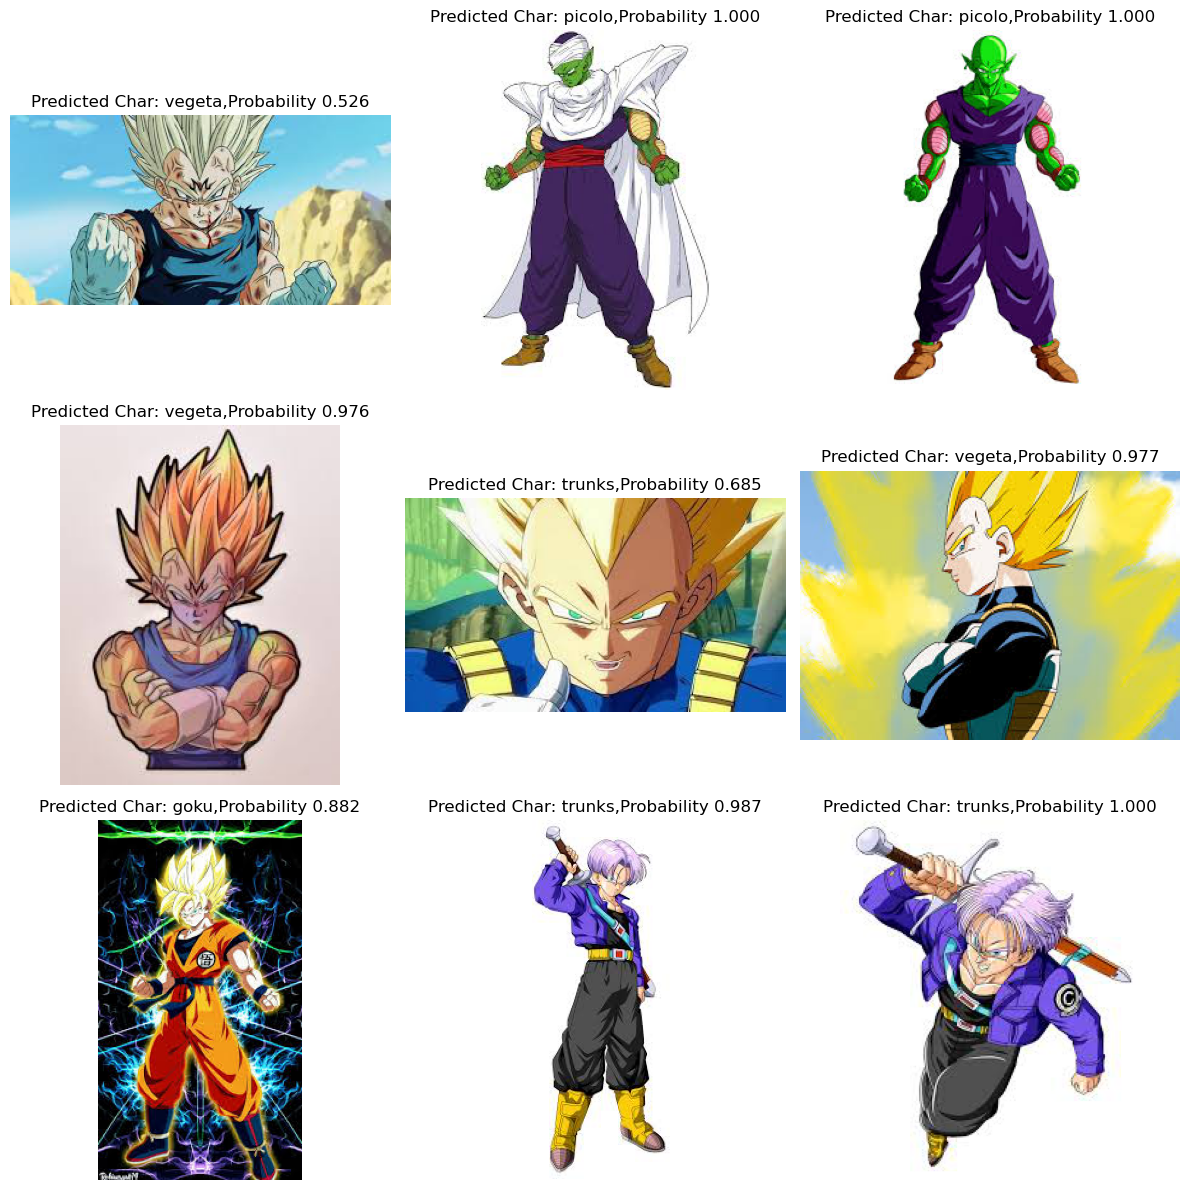

In [180]:
predict_and_plot_images(model=best_model,
                        class_names=class_names,
                        image_paths=test_image_path_samples,
                        image_size=(224, 224))

### 9. Predict on custom image

In [185]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. create a function to take in the model and other required args
def predict_and_plot_image(model: torch.nn.Module,
                          class_names: List[str],
                          image_path: str,
                          transform: torchvision.transforms = None,
                          image_size: Tuple[int, int] = (224, 224),
                           device: torch.device = "cpu"
):
    #2. open the image using PIL
    target_image = Image.open(image_path)

    #3. create a transform for the target image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
                                            )

    #4. Make sure the model is on the target device
    model.to(device)

    ### Prediction on the target Image

    #5. Put the model in eval mode 
    model.eval()
    with torch.inference_mode():
        #6. Transform the target image and add an extra dimension for batch size ->[B,c,H,W]
        transformed_image = image_transform(target_image).unsqueeze(dim = 0)

        #7. Make prediction on the transformed image and also ensuring its on the target device
        pred_logits = model(transformed_image).to(device)

    #8. Converting the logits into prediction probs
    pred_probs = torch.softmax(pred_logits, dim = 1)

    #9. Converitng the prediction probs into prediction labels
    pred_label = torch.argmax(pred_probs, dim = 1)

    #10. Plot the target image by titling the label with the predicted class name
    plt.figure()
    plt.imshow(target_image)
    plt.title(f"Predicted Class: {class_names[pred_label]},  with Probability {pred_probs.max():.3f}")
    plt.axis(False);
    

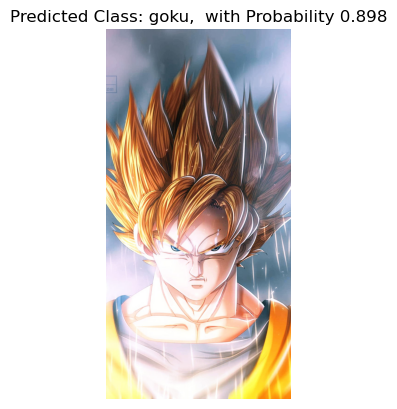

In [186]:
## Download Custom Images

# Setup custom image path
custom_image_path = "/Users/venu/Documents/Productivity/Pytorch Tutorials/data/dragon_ball_images_20percent/goku.jpg"

# predict on custom image
predict_and_plot_image(model = best_model,
                      image_path= custom_image_path,
                      class_names = class_names)